# Stochastic Processes: <br>Data Analysis and Computer Simulation
<br>


# Stochastic processes in the real world
<br>


# 3. A Stochastic Dealer Model II
<br>

# 3.1. Preparation

In [1]:
%matplotlib inline
import numpy as np  # import numpy library as np
import math         # use mathematical functions defined by the C standard
import matplotlib.pyplot as plt # import pyplot library as plt 
import pandas as pd # import pandas library as pd
from datetime import datetime
#from pandas_datareader import data as pdr
#from pandas_datareader import wb   as pwb
plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':16,'axes.labelsize':20,'axes.titlesize':20,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)

In [2]:
# Logarithmic return of price time series
def logreturn(St,tau=1):
    return np.log(St[tau:])-np.log(St[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
# normalize data to have unit variance (<(x - <x>)^2> = 1)
def normalized(data):
    return ((data)/np.sqrt(np.var(data)))
# compute normalized probability distribution function
def pdf(data,bins=50):
    hist,edges=np.histogram(data[~np.isnan(data)],bins=bins,density=True) # remove NaNs and compute histogram
    edges   = (edges[:-1] + edges[1:])/2.0 # get bar center
    nonzero = hist > 0.0                   # non-zero points 
    return edges[nonzero], hist[nonzero]
# add logarithmic return data to pandas DataFrame data using the 'Adjusted Close' stock price for each day
def computeReturn(data, name, tau):
    data[name]=pd.Series(normalized(logreturn(data['Adj Close'].values, tau)),index=data.index[:-tau])

In [9]:
#end_time   = datetime.now()
#start_time = datetime(end_time.year - 20, end_time.month, end_time.day)
#toyota     = pdr.DataReader('7203','yahoo',start_time,end_time)  # import toyota stock
def read_yahoo_data(fname):
    return pd.read_csv(fname, index_col=0, parse_dates=[0],na_values="null").dropna()
toyota     = read_yahoo_data('./yahoo_finance/TM.csv')
computeReturn(toyota, 'Return d1', 1)

# 3.2. The Dealer Model 
- K. Yamada, H. Takayasu, T. Ito and M. Takayasu, <i>Physical Revew E</i> <b>79</b>, 051120 (2009).

<!--
<img src="fig/dealers0.svg" width=700>
-->
![](fig/dealers0.png)

- Transaction criterion
$$
	\lvert p_i(t) - p_j(t) \rvert \ge L\tag{L1} 
$$
- Market price of transaction
$$
	P = \frac{1}{2}\left(p_1 + p_2\right) \tag{L2}
$$
- Logarithmic price return 
$$
  G_\tau(t) \equiv \log{P(t+\tau)} - \log{P(t)} \tag{L3} 
$$

# 3.3. The dealer model with memory (model 2)

- To improve the model, Yamada et al. (PRE 79, 051120, 2009) added the effect of "trend-following" predictions.

- Dynamics is captured by a random walk with a drift/memory term

$$
p_i(t + \Delta t) = p_i(t) + d\langle\Delta P\rangle_M \Delta t + c f_i(t), \qquad i=1,2\tag{L4}
$$

$$
f_i(t) = \begin{cases}
    +\Delta p & \mathrm{prob.} 1/2 \\
    -\Delta p & \mathrm{prob.} 1/2\tag{L5}
\end{cases}
$$
- The constant $d$ determines whether the dealer is a "trend-follower" ($d>0$) or a "contrarian" ($d < 0$)

- The added term represents a moving average over the previous price changes

$$
\langle\Delta P\rangle_M = \frac{2}{M (M+1)}\sum_{k=0}^{M-1}(M-k)\Delta P(n-k)\tag{L6}
$$

$$
\Delta P(n) = P(n) - P(n-1) : \textrm{Market price change at the n-th tick}
$$

- $\langle\Delta P\rangle_M$ is constant during the Random-Walk process, it is only updated at the transaction events

# 3.3. Dealer model as a 2D random walk
- The dealer model can again be understood as a standard 2D Random walk with absorbing boundaries.
- Introduce the price difference $D(t)$ and average $A(t)$
$$
D(t) = p_1(t) - p_2(t) \tag{L7}
$$
$$
A(t) = \frac{1}{2}\big(p_1(t) + p_2(t)\big)\tag{L8}
$$
- Dynamics of $D$ and $A$ describe a 2D random walk
$$
D(t+\Delta t) = D(t) + \begin{cases}
+2 c \Delta p & \textrm{probability 1/4} \\
0 & \textrm{probability 1/2} \\
-2 c\Delta p& \textrm{probability 1/4}
\end{cases} \tag{L9} \\
$$
$$
A(t+\Delta t) = A(t) + d\langle\Delta P\rangle_M \Delta t + \begin{cases}
+c\Delta p & \textrm{probability 1/4}\\
0 & \textrm{probability 1/2}\\
-c\Delta p &\textrm{probability 1/4}
\end{cases}\tag{L10}
$$
- When $D(t) = \pm L$ a transaction occurs and the random walk ends, the "particle" is absorbed by the boundary.

In [10]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.25, 'M':1} # define model parameters
def model2RW(params,p0,deltapm):        # simulate Random-Walk for 1 transaction
    price = np.array([p0[0], p0[1]])    # initialize mid-prices for dealers p_1 and p_2
    cdp   = params['c']*params['dp']    # define random step size
    ddt   = params['d']*params['dt']    # define trend drift term
    Dt    = [price[0]-price[1]]         # initialize price difference as empty list
    At    = [np.average(price)]         # initialize avg price as empy list
    while np.abs(price[0]-price[1]) < params['L']:
        price=price+np.random.choice([-cdp,cdp],size=2) # random walk step for mid-prices Eq. (L4)
        price=price+ddt*deltapm         # Model 2 : add trend-following term in Eq. (L4)
        Dt.append(price[0]-price[1])
        At.append(np.average(price))
    return np.array(Dt),np.array(At)-At[0] # return difference array and average centered at zero

Model 1 : number of steps =  9248 , price change =  -0.0027000000000896307
Model 2 : number of steps =  9248 , price change =  0.0007676249911554578


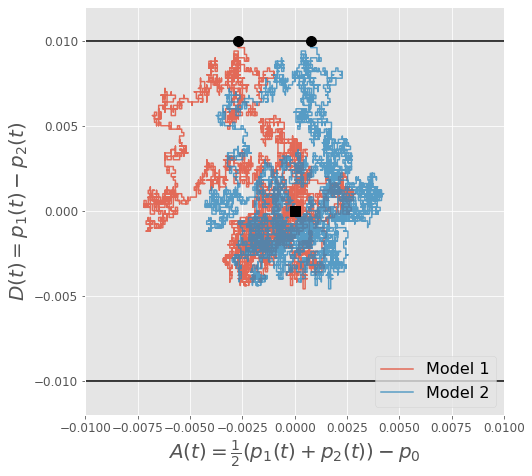

In [11]:
fig,ax=plt.subplots(figsize=(7.5,7.5),subplot_kw={'xlabel':r'$A(t) = \frac{1}{2}\left(p_1(t) + p_2(t)\right) - p_0$', 'ylabel':r'$D(t) = p_1(t) - p_2(t)$'})
p0 = [100.25, 100.25]
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.25, 'M':1} # define model parameters
for deltapm,lbl in zip([0, 0.003], ['Model 1', 'Model 2']):
    np.random.seed(123456)
    Dt,At = model2RW(params, p0, deltapm)
    ax.plot(At,Dt,alpha=0.8,label=lbl) #plot random walk trajectory
    ax.plot(At[-1],Dt[-1],marker='o',color='k', markersize=10) #last point
    print(lbl+' : number of steps = ',len(At),', price change = ', At[-1])
ax.plot(0, 0, marker='s', color='k', markersize=10) # starting position
ax.plot([-0.01,0.03],[params['L'],params['L']],color='k') #top absorbing boundary P=L
ax.plot([-0.01,0.03],[-params['L'],-params['L']],color='k') #bottom absorbing boundary P=-L
ax.set_ylim([-0.012, 0.012])
ax.set_xlim([-0.01, 0.01])
ax.legend(loc=4,framealpha=0.8)
plt.show()

# 3.4. Perform simulations

In [12]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.25, 'M':1} # define model parameters
def model2(params,p0,numt):
    def avgprice(dpn): # compute running average Eq.(L6)
        M = len(dpn)    # 
        weights  = np.array(range(1,M+1))*2.0/(M*(M+1))
        return weights.dot(dpn)
    
    mktprice = np.zeros(numt)   # initialize market price P(n)
    dmktprice= np.zeros(numt)   # initialize change in price dP(n) needed for running average
    ticktime = np.zeros(numt,dtype=np.int) #initialize array for tick times
    price    = np.array([p0[0], p0[1]])    #initialize dealer's mid-price (p1,p2)
    time,tick= 0,0 # real time(t) and time time (n)
    deltapm  = 0.0 # trend term d <dP>_m dt for current random walk
    cdp      = params['c']*params['dp'] # define random step size
    ddt      = params['d']*params['dt'] # define amplitude of trend term
    while tick < numt: # loop over ticks
        while np.abs(price[0]-price[1]) < params['L']: # transaction criterion Eq.(L1)
            price = price + deltapm + np.random.choice([-cdp,cdp], size=2) # random walk step Eq.(L4)
            time += 1 #update ral time
        price[:]       = np.average(price) #set mid-prices to new market price Eq.(L2)
        mktprice[tick] = price[0]  # save market price
        dmktprice[tick]= mktprice[tick] - mktprice[np.max([0,tick-1])] # save dP(n) = P(n) - P(n-1)
        ticktime[tick] = time # save transaction time
        tick += 1 #update ticks
        tick0 = np.max([0, tick - params['M']]) #compute tick start for running average
        deltapm = avgprice(dmktprice[tick0:tick])*ddt #compute updated trend term for current tick time
    return ticktime,mktprice

- A simulation is performed if you run the cell below, but depending on your computer power it may take quite long time until it finishes with properly creating the simulation data "model2.txt".
- You may skip this cell and use pre-calculated simulation data "model2.txt" which can be downloaded from our website to continue further data analyses.

In [ ]:
np.random.seed(0)
ticktime2,mktprice2 = model2(params, [100.25, 100.25], 5000)
np.savetxt('model2.txt',np.transpose([ticktime2, mktprice2]))

# 3.5. Analyses

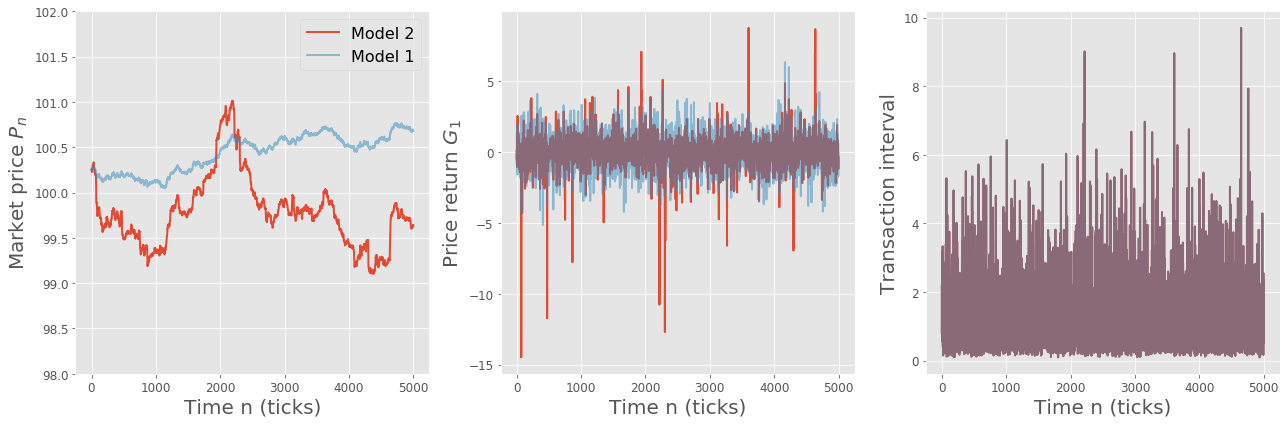

In [13]:
ticktime,mktprice=np.loadtxt('model1.txt',unpack=True) # read saved data from file
ticktime2,mktprice2=np.loadtxt('model2.txt', unpack=True) 
timeinterval=normalized((ticktime[1:]-ticktime[0:-1])*params['dt']) # compute time difference between subsequent trades
timeinterval2=normalized((ticktime2[1:]-ticktime2[0:-1])*params['dt'])
dprice=normalized(logreturn(mktprice,1)) # compute logarithmic return of the price over one tick, normalized to have unit variance (Eq. J2)
dprice2=normalized(logreturn(mktprice2,1))
fig,[ax,bx,cx]=plt.subplots(figsize=(18,6),ncols=3,subplot_kw={'xlabel':r'Time n (ticks)'})
ax.plot(mktprice2, lw=2, label='Model 2')
ax.plot(mktprice, alpha=0.5, lw=2, label='Model 1')
ax.legend()
ax.set_ylim(98,102)
ax.set_ylabel(r'Market price $P_n$')
bx.plot(dprice2, lw=2)
bx.plot(dprice, alpha=0.5, lw=2)
bx.set_ylabel(r'Price return $G_1$')
cx.plot(timeinterval2,  lw=2)
cx.plot(timeinterval, alpha=0.5, lw=2)
cx.set_ylabel(r'Transaction interval')
fig.tight_layout() # get nice spacing between plots
plt.show()

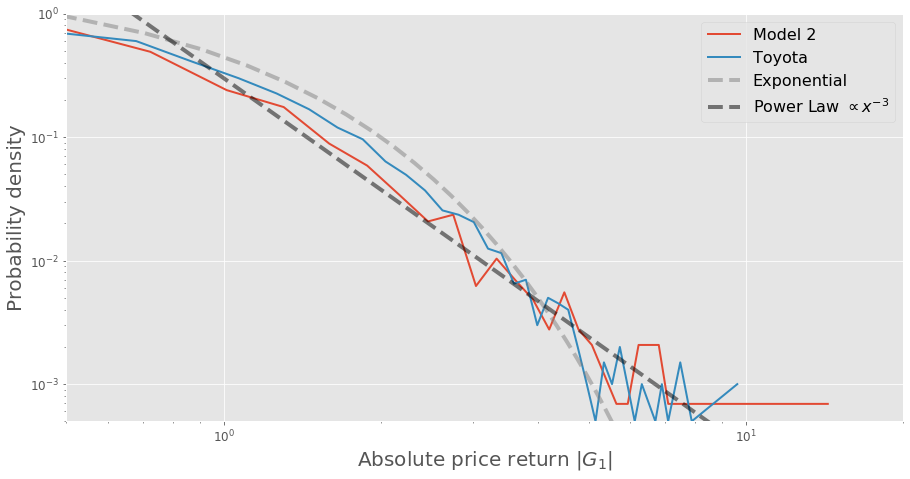

In [14]:
fig,ax,=plt.subplots(figsize=(15,7.5),subplot_kw={'xlabel':r'Absolute price return $|G_1|$', 'ylabel':r'Probability density'})
for data,lbl in zip([dprice2, toyota['Return d1']], ['Model 2', 'Toyota']):
    edges, hist = pdf(np.abs(data), bins=50)
    ax.plot(edges, hist, label=lbl, lw=2)
x = np.linspace(0.1, 10)
ax.plot(x, 2*np.exp(-1.5*x),lw=4,color='gray',ls='--',alpha=0.5,label=r'Exponential')
ax.plot(x, 0.3*x**(-3), lw=4, color='k', ls='--', alpha=0.5, label=r'Power Law $\propto x^{-3}$')
ax.set_xlim(5e-1, 2e1)
ax.set_ylim(5e-4, 1)
ax.legend()
ax.semilogx()
ax.semilogy()
plt.show()

In [15]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.00, 'M':10} # define model parameters
def model2t(params,p0,numt):
    def avgprice(dpn): # compute running average Eq.(L6)
        M = len(dpn)    # 
        weights  = np.array(range(1,M+1))*2.0/(M*(M+1))
        return weights.dot(dpn)
    def dtime(i, dpm): # return time varying d-coefficient
        if i <= 1000:  # contrarians
            return -params['d']
        elif i <= 2000:# random walkers: no memory
            return 0.0
        elif i <= 3000:# trend-followers
            return params['d']
        elif dpm >= 0.0: # trend-followers if running average increasing
            return params['d']
        else: # contrarians if running average decreasing
            return -params['d']   
    mktprice = np.zeros(numt)   # initialize market price P(n)
    dmktprice= np.zeros(numt)   # initialize change in price dP(n) needed for running average
    ticktime = np.zeros(numt,dtype=np.int) #initialize array for tick times
    price    = np.array([p0[0], p0[1]])    #initialize dealer's mid-price (p1,p2)
    time,tick= 0,0 # real time(t) and time time (n)
    deltapm  = 0.0 # trend term d <dP>_m dt for current random walk
    cdp      = params['c']*params['dp'] # define random step size
    while tick < numt: # loop over ticks
        ddt      = dtime(tick, deltapm)*params['dt'] # define amplitude of trend term (now time dependent)
        while np.abs(price[0]-price[1]) < params['L']: # transaction criterion Eq.(L1)
            price = price + deltapm + np.random.choice([-cdp,cdp], size=2) # random walk step Eq.(L4)
            time += 1 #update ral time
        price[:]       = np.average(price) #set mid-prices to new market price Eq.(L2)
        mktprice[tick] = price[0]  # save market price
        dmktprice[tick]= mktprice[tick] - mktprice[np.max([0,tick-1])] # save dP(n) = P(n) - P(n-1)
        ticktime[tick] = time # save transaction time
        tick += 1 #update ticks
        tick0 = np.max([0, tick - params['M']]) #compute tick start for running average
        deltapm = avgprice(dmktprice[tick0:tick])*ddt #compute updated trend term for current tick time
    return ticktime,mktprice

- A simulation is performed if you run the cell below, but depending on your computer power it may take quite long time until it finishes with properly creating the simulation data "model2t.txt".
- You may skip this cell and use pre-calculated simulation data "model2t.txt" which can be downloaded from our website to continue further data analyses.

In [ ]:
np.random.seed(0)
ticktime2t,mktprice2t = model2t(params, [100.25, 100.25], 4001)
np.savetxt('model2t.txt',np.transpose([ticktime2t, mktprice2t]))

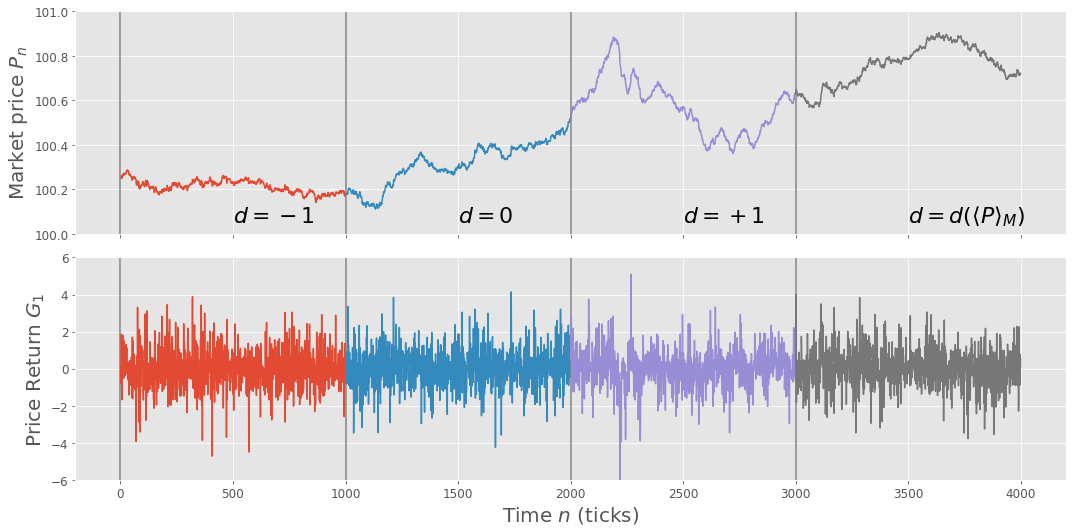

In [16]:
ticktime2t,mktprice2t=np.loadtxt('model2t.txt',unpack=True) # read saved data from file
fig,[ax,bx]=plt.subplots(figsize=(15,7.5),nrows=2, sharex=True)
for i,lbl in zip(range(4), [r'$d=-1$', r'$d=0$', r'$d=+1$', r'$d=d(\left\langle P\right\rangle_M)$']):
    n0,n1 = i*1000, (i+1)*1000
    dprice=normalized(logreturn(mktprice2t[n0:n1],1))
    ax.plot(range(n0,n1), mktprice2t[n0:n1])
    ax.plot([n0,n0],[100,102], color='gray')
    ax.text(n0+500, 100.05, lbl, fontsize=22)
    bx.plot([n0,n0],[-6,6],color='gray')
    bx.plot(range(n0+1,n1), dprice)
ax.set_ylim(100,101)
bx.set_ylim(-6,6)
ax.set_ylabel(r'Market price $P_n$')
bx.set_ylabel(r'Price Return $G_1$')
bx.set_xlabel(r'Time $n$ (ticks)')
fig.tight_layout()
plt.show()